Soroush Famili, James Lu, Nithanth Ram

# Lab 9

This lab contains a number of different goals and ideas. The first part is low-level, and intended
to get you playing directly with pytorch. The middle part introduces you to the fascinating world of
Adversarial Attacks, but also gives practice with the important idea that you the power of torch (or
tensorflow) is that they allow you to compute derivatives of various kinds, and these can be used
for various interesting applications. Finally, the third part introduces you to powerful highlevel
tools built on top of pytorch. I hope that all of these ideas will be interesting, and also potentially
interesting and useful for your final projects.

In [25]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
import os
import time
from sklearn.metrics import roc_auc_score
from scipy.signal import correlate

# Problem 1: Convolutions

#### 1. Compute the output of a 1D convolution layer if the input is a single-channel vector [1,-1,3,4,4] and the kernal is [1,1] for stride =1 and padding =0.


In [26]:
x1 = [1, -1, 3, 4, 4]
kernel1 = [1, 1]

output = correlate(x1, kernel1, mode="valid")

print(output)

[0 2 7 8]


### 2. Compute the output of a 1D convolution layer if the input is a single-channel vector [1,-1,3,4,4] and the kernal is [1,-1] for stride =1 and padding =1 (padding one means on both sides)


In [27]:
x2 = [0, 1, -1, 3, 4, 4, 0]
kernel2 = [1, -1]

output = correlate(x2, kernel2, mode="valid")

print(output)

[-1  2 -4 -1  0  4]


### 3.Write pytorch code that computes these outputs. Create the corresponding tensors and use torch.nn.Conv1d and ConvTranspose1d.

In [28]:
x_tensor = torch.tensor([[[1, -1, 3, 4, 4]]])
kernel1_tensor = torch.tensor([[[1, 1]]])
kernel2_tensor = torch.tensor([[[1, -1]]])

conv1 = nn.Conv1d(in_channels=1, out_channels=1, kernel_size=2, stride=1, padding=0, bias=False)
conv1.weight.data = kernel1_tensor
y1 = conv1(x_tensor)

conv2 = nn.Conv1d(in_channels=1, out_channels=1, kernel_size=2, stride=1, padding=1, bias=False)
conv2.weight.data = kernel2_tensor
y2 = conv2(x_tensor)

print(f"Kernel={kernel1}, Padding=0, Convolution={y1}")
print(f"Kernel={kernel2}, Padding=1, Convolution={y2}")

Kernel=[1, 1], Padding=0, Convolution=tensor([[[0, 2, 7, 8]]], grad_fn=<SqueezeBackward1>)
Kernel=[1, -1], Padding=1, Convolution=tensor([[[-1,  2, -4, -1,  0,  4]]], grad_fn=<SqueezeBackward1>)


# Problem 2: Training a CIFAR-10 CNN classifier

In this problem we will follow a tutorial to build a Convolutional neural network that classifies
images from the CIFAR-10 dataset and then modify it.

## 1. Start by implementing and running this tutorial. https://www.stefanfiott.com/machine-learning/cifar-10-classifier-using-cnn-in-pytorch/ Show the accuracy you get and also the confusion matrix you obtain for the 10 classes.

In [29]:
transform = transforms.Compose(
[transforms.ToTensor(),
transforms.Normalize((.5, .5, .5), (.5, .5, .5))])

In [33]:
trainset = torchvision.datasets.CIFAR10(root='/home/CIFAR-10 Classifier Using CNN in PyTorch/data/',
                                       train=True,
                                       download=True,
                                       transform=transform)



0it [00:00, ?it/s]
  8%|█████▍                                                          | 14360576/170498071 [00:07<00:56, 2742429.83it/s]


 31%|███████████████████▌                                            | 52273152/170498071 [00:15<00:12, 9609537.71it/s]


 83%|███████████████████████████████████████████████████▍          | 141475840/170498071 [00:23<00:02, 11755686.96it/s]


100%|█████████████████████████████████████████████████████████████▉| 170295296/170498071 [00:25<00:00, 10587301.81it/s]

Extracting /home/CIFAR-10 Classifier Using CNN in PyTorch/data/cifar-10-python.tar.gz to /home/CIFAR-10 Classifier Using CNN in PyTorch/data/


In [34]:
trainloader = torch.utils.data.DataLoader(trainset,
                                         batch_size=4,
                                         shuffle=True)

In [35]:
testset = torchvision.datasets.CIFAR10(root='./data',
                                      train=False,
                                      download=True,
                                      transform=transform)

Files already downloaded and verified


In [36]:
testloader = torch.utils.data.DataLoader(testset,
                                        batch_size=4,
                                        shuffle=False)

In [37]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 
           'dog', 'frog', 'horse', 'ship', 'truck')

In [38]:
def convert_to_imshow_format(image):
    image = image/2 + .5
    image = image.numpy()
    
    return image.transpose(1,2,0)

In [39]:
dataiter = iter(trainloader)
images, labels = dataiter.next()

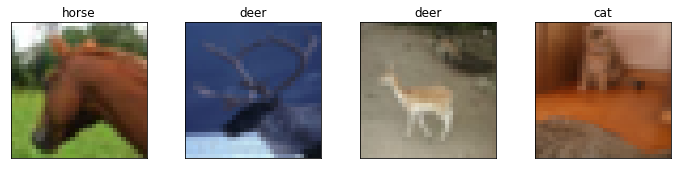


170500096it [00:42, 10587301.81it/s]                                                                                   

In [40]:
fig, axes = plt.subplots(1, len(images), figsize=(12, 2.5))
for idx, image in enumerate(images):
    axes[idx].imshow(convert_to_imshow_format(image))
    axes[idx].set_title(classes[labels[idx]])
    axes[idx].set_xticks([])
    axes[idx].set_yticks([])

In [41]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    

In [42]:
net = Net()

In [43]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [44]:
model_directory_path = '/home/CIFAR-10 Classifier Using CNN in PyTorch/model/'
model_path = model_directory_path + 'cifar-10-cnn-model.pt'
start_time = time.time()
if not os.path.exists(model_directory_path):
    os.makedirs(model_directory_path)

if os.path.isfile(model_path):
    net.load_state_dict(torch.load(model_path))
    print('Loaded model parameters from disk.')
else:
    for epoch in range(2):
        
        running_loss = 0
        for i, data in enumerate(trainloader, 0):
            
            inputs, labels = data
            
            optimizer.zero_grad()
            
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            if i%2000 == 1999:
                print('[%d, %5d] loss: %.3f' %
                      (epoch + 1, i + 1, running_loss / 2000))
                running_loss = 0.0
                
        print('Finished Training.')
        torch.save(net.state_dict(), model_path)
        print('Saved model parameters to disk.')
        print(f"{(time.time() - start_time)/60} minutes")

[1,  2000] loss: 2.223
[1,  4000] loss: 1.872
[1,  6000] loss: 1.695
[1,  8000] loss: 1.562
[1, 10000] loss: 1.507
[1, 12000] loss: 1.470
Finished Training.
Saved model parameters to disk.
0.9195075670878092 minutes
[2,  2000] loss: 1.380
[2,  4000] loss: 1.362
[2,  6000] loss: 1.332
[2,  8000] loss: 1.305
[2, 10000] loss: 1.280
[2, 12000] loss: 1.258
Finished Training.
Saved model parameters to disk.
1.9028610388437908 minutes


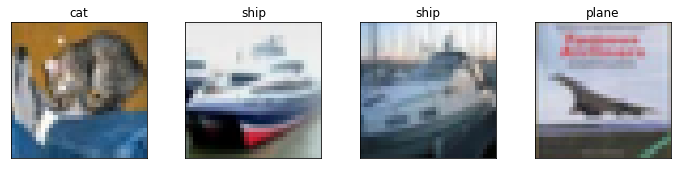

In [45]:
dataiter = iter(testloader)
images, labels = dataiter.next()

fig, axes = plt.subplots(1, len(images), figsize=(12,2.5))
for idx, image in enumerate(images):
    axes[idx].imshow(convert_to_imshow_format(image))
    axes[idx].set_title(classes[labels[idx]])
    axes[idx].set_xticks([])
    axes[idx].set_yticks([])

In [46]:
outputs = net(images)
outputs

tensor([[-0.7369, -3.2526,  1.2529,  2.6959,  1.1119,  1.5429,  2.5668, -1.3024,
         -1.7363, -2.7540],
        [ 4.8153,  8.3624, -2.7955, -3.9319, -5.9884, -5.9792, -5.0595, -3.7859,
          7.9257,  6.1094],
        [ 2.8054,  3.0774, -0.4360, -1.6712, -1.6471, -3.0290, -2.8189, -2.0003,
          3.5910,  1.9609],
        [ 4.0273,  2.7951, -0.6243, -2.1930, -1.9753, -4.1967, -3.8447, -2.5049,
          5.7946,  2.6068]], grad_fn=<AddmmBackward>)

In [47]:
sm = nn.Softmax(dim=1)
sm_outputs = sm(outputs)
sm_outputs

tensor([[1.1938e-02, 9.6471e-04, 8.7317e-02, 3.6963e-01, 7.5830e-02, 1.1669e-01,
         3.2487e-01, 6.7816e-03, 4.3944e-03, 1.5882e-03],
        [1.6184e-02, 5.6176e-01, 8.0122e-06, 2.5715e-06, 3.2893e-07, 3.3195e-07,
         8.3270e-07, 2.9760e-06, 3.6300e-01, 5.9034e-02],
        [1.9948e-01, 2.6184e-01, 7.8011e-03, 2.2686e-03, 2.3239e-03, 5.8350e-04,
         7.1992e-04, 1.6323e-03, 4.3762e-01, 8.5730e-02],
        [1.3505e-01, 3.9387e-02, 1.2892e-03, 2.6856e-04, 3.3390e-04, 3.6212e-05,
         5.1494e-05, 1.9661e-04, 7.9076e-01, 3.2628e-02]],
       grad_fn=<SoftmaxBackward>)

In [48]:
probs, index = torch.max(sm_outputs, dim=1)

for p, i in zip(probs, index):
    print('{0} - {1:.4f}'.format(classes[i], p))

cat - 0.3696
car - 0.5618
ship - 0.4376
ship - 0.7908


In [49]:
total_correct = 0
total_images = 0
confusion_matrix = np.zeros([10,10], int)
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total_images += labels.size(0)
        total_correct += (predicted == labels).sum().item()
        for i, l in enumerate(labels):
            confusion_matrix[l.item(), predicted[i].item()] += 1 

model_accuracy = total_correct / total_images * 100
print('Model accuracy on {0} test images: {1:.2f}%'.format(total_images, model_accuracy))

Model accuracy on 10000 test images: 55.78%


In [50]:
print('{0:10s} - {1}'.format('Category','Accuracy'))
for i, r in enumerate(confusion_matrix):
    print('{0:10s} - {1:.1f}'.format(classes[i], r[i]/np.sum(r)*100))

Category   - Accuracy
plane      - 57.8
car        - 71.0
bird       - 54.8
cat        - 19.4
deer       - 32.4
dog        - 46.4
frog       - 68.7
horse      - 67.6
ship       - 75.4
truck      - 64.3


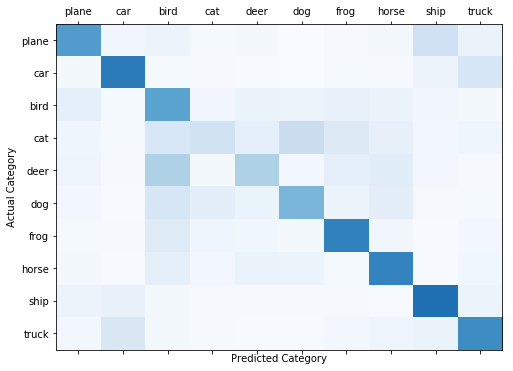

In [51]:
fig, ax = plt.subplots(1,1,figsize=(8,6))
ax.matshow(confusion_matrix, aspect='auto', vmin=0, vmax=1000, cmap=plt.get_cmap('Blues'))
plt.ylabel('Actual Category')
plt.yticks(range(10), classes)
plt.xlabel('Predicted Category')
plt.xticks(range(10), classes)
plt.show()

In [52]:
print('actual/pred'.ljust(16), end='')
for i,c in enumerate(classes):
    print(c.ljust(10), end='')
print()
for i,r in enumerate(confusion_matrix):
    print(classes[i].ljust(16), end='')
    for idx, p in enumerate(r):
        print(str(p).ljust(10), end='')
    print()
    
    r = r/np.sum(r)
    print(''.ljust(16), end='')
    for idx, p in enumerate(r):
        print(str(p).ljust(10), end='')
    print()

actual/pred     plane     car       bird      cat       deer      dog       frog      horse     ship      truck     
plane           578       34        56        13        20        3         11        17        205       63        
                0.578     0.034     0.056     0.013     0.02      0.003     0.011     0.017     0.205     0.063     
car             20        710       13        9         6         1         14        10        57        160       
                0.02      0.71      0.013     0.009     0.006     0.001     0.014     0.01      0.057     0.16      
bird            86        12        548       35        65        59        78        66        34        17        
                0.086     0.012     0.548     0.035     0.065     0.059     0.078     0.066     0.034     0.017     
cat             44        15        156       194       92        222       125       82        26        44        
                0.044     0.015     0.156     0.194     0.092   

## 2. Show the convolutional layer kernels you learned in the first convolutional layer.

In [53]:
def plot_kernels(tensor, num_cols=6):
    num_rows = 1
    fig = plt.figure(figsize=(num_cols, num_rows))
    i = 0
    for t in tensor:
        ax1 = fig.add_subplot(num_rows, num_cols, i+1)
        pilTrans = transforms.ToPILImage()
        pilImg = pilTrans(t)
        ax1.imshow(pilImg, interpolation='none')
        ax1.axis('off')
        ax1.set_xticklabels([])
        ax1.set_yticklabels([])
        i += 1
    
    plt.subplots_adjust(wspace=.1, hspace=.1)
    plt.show()

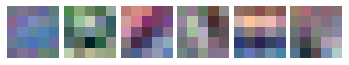

In [54]:
kernels = net.conv1.weight.detach().clone()
kernels = kernels - kernels.min()
kernels = kernels/kernels.max()
plot_kernels(kernels)

## 3. Replace the architecture with AlexNet (https://github.com/icpm/pytorch-cifar10/blob/master/models/AlexNet.py) and report accuracy. Tune hyperparameters to get the best possible accuracy on a test set.

In [55]:
import torch.nn as nn

NUM_CLASSES = 10


class AlexNet(nn.Module):
    def __init__(self, num_classes=NUM_CLASSES):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(64, 192, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),
        )
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 2 * 2, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), 256 * 2 * 2)
        x = self.classifier(x)
        return x

In [56]:
net = AlexNet()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [61]:
# Takes 55 minutes per epoch. Run at your peril

for epoch in range(1):

    running_loss = 0
    for i, data in enumerate(trainloader, 0):
        print(f"Progress: {i/125}%")
        inputs, labels = data

        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i%2000 == 1999:
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

    print('Finished Training.')
    torch.save(net.state_dict(), model_path)
    print('Saved model parameters to disk.')
    print(f"{(time.time() - start_time)/60} minutes")

Progress: 0.0%
Progress: 0.008%
Progress: 0.016%
Progress: 0.024%
Progress: 0.032%
Progress: 0.04%
Progress: 0.048%
Progress: 0.056%
Progress: 0.064%
Progress: 0.072%
Progress: 0.08%
Progress: 0.088%
Progress: 0.096%
Progress: 0.104%
Progress: 0.112%
Progress: 0.12%
Progress: 0.128%
Progress: 0.136%
Progress: 0.144%
Progress: 0.152%
Progress: 0.16%
Progress: 0.168%
Progress: 0.176%
Progress: 0.184%
Progress: 0.192%
Progress: 0.2%
Progress: 0.208%
Progress: 0.216%
Progress: 0.224%
Progress: 0.232%
Progress: 0.24%
Progress: 0.248%
Progress: 0.256%
Progress: 0.264%
Progress: 0.272%
Progress: 0.28%
Progress: 0.288%
Progress: 0.296%
Progress: 0.304%
Progress: 0.312%
Progress: 0.32%
Progress: 0.328%
Progress: 0.336%
Progress: 0.344%
Progress: 0.352%
Progress: 0.36%
Progress: 0.368%
Progress: 0.376%
Progress: 0.384%
Progress: 0.392%
Progress: 0.4%
Progress: 0.408%
Progress: 0.416%
Progress: 0.424%
Progress: 0.432%
Progress: 0.44%
Progress: 0.448%
Progress: 0.456%
Progress: 0.464%
Progress: 0.

Progress: 3.904%
Progress: 3.912%
Progress: 3.92%
Progress: 3.928%
Progress: 3.936%
Progress: 3.944%
Progress: 3.952%
Progress: 3.96%
Progress: 3.968%
Progress: 3.976%
Progress: 3.984%
Progress: 3.992%
Progress: 4.0%
Progress: 4.008%
Progress: 4.016%
Progress: 4.024%
Progress: 4.032%
Progress: 4.04%
Progress: 4.048%
Progress: 4.056%
Progress: 4.064%
Progress: 4.072%
Progress: 4.08%
Progress: 4.088%
Progress: 4.096%
Progress: 4.104%
Progress: 4.112%
Progress: 4.12%
Progress: 4.128%
Progress: 4.136%
Progress: 4.144%
Progress: 4.152%
Progress: 4.16%
Progress: 4.168%
Progress: 4.176%
Progress: 4.184%
Progress: 4.192%
Progress: 4.2%
Progress: 4.208%
Progress: 4.216%
Progress: 4.224%
Progress: 4.232%
Progress: 4.24%
Progress: 4.248%
Progress: 4.256%
Progress: 4.264%
Progress: 4.272%
Progress: 4.28%
Progress: 4.288%
Progress: 4.296%
Progress: 4.304%
Progress: 4.312%
Progress: 4.32%
Progress: 4.328%
Progress: 4.336%
Progress: 4.344%
Progress: 4.352%
Progress: 4.36%
Progress: 4.368%
Progress: 4

Progress: 7.808%
Progress: 7.816%
Progress: 7.824%
Progress: 7.832%
Progress: 7.84%
Progress: 7.848%
Progress: 7.856%
Progress: 7.864%
Progress: 7.872%
Progress: 7.88%
Progress: 7.888%
Progress: 7.896%
Progress: 7.904%
Progress: 7.912%
Progress: 7.92%
Progress: 7.928%
Progress: 7.936%
Progress: 7.944%
Progress: 7.952%
Progress: 7.96%
Progress: 7.968%
Progress: 7.976%
Progress: 7.984%
Progress: 7.992%
Progress: 8.0%
Progress: 8.008%
Progress: 8.016%
Progress: 8.024%
Progress: 8.032%
Progress: 8.04%
Progress: 8.048%
Progress: 8.056%
Progress: 8.064%
Progress: 8.072%
Progress: 8.08%
Progress: 8.088%
Progress: 8.096%
Progress: 8.104%
Progress: 8.112%
Progress: 8.12%
Progress: 8.128%
Progress: 8.136%
Progress: 8.144%
Progress: 8.152%
Progress: 8.16%
Progress: 8.168%
Progress: 8.176%
Progress: 8.184%
Progress: 8.192%
Progress: 8.2%
Progress: 8.208%
Progress: 8.216%
Progress: 8.224%
Progress: 8.232%
Progress: 8.24%
Progress: 8.248%
Progress: 8.256%
Progress: 8.264%
Progress: 8.272%
Progress: 

Progress: 11.616%
Progress: 11.624%
Progress: 11.632%
Progress: 11.64%
Progress: 11.648%
Progress: 11.656%
Progress: 11.664%
Progress: 11.672%
Progress: 11.68%
Progress: 11.688%
Progress: 11.696%
Progress: 11.704%
Progress: 11.712%
Progress: 11.72%
Progress: 11.728%
Progress: 11.736%
Progress: 11.744%
Progress: 11.752%
Progress: 11.76%
Progress: 11.768%
Progress: 11.776%
Progress: 11.784%
Progress: 11.792%
Progress: 11.8%
Progress: 11.808%
Progress: 11.816%
Progress: 11.824%
Progress: 11.832%
Progress: 11.84%
Progress: 11.848%
Progress: 11.856%
Progress: 11.864%
Progress: 11.872%
Progress: 11.88%
Progress: 11.888%
Progress: 11.896%
Progress: 11.904%
Progress: 11.912%
Progress: 11.92%
Progress: 11.928%
Progress: 11.936%
Progress: 11.944%
Progress: 11.952%
Progress: 11.96%
Progress: 11.968%
Progress: 11.976%
Progress: 11.984%
Progress: 11.992%
Progress: 12.0%
Progress: 12.008%
Progress: 12.016%
Progress: 12.024%
Progress: 12.032%
Progress: 12.04%
Progress: 12.048%
Progress: 12.056%
Progr

Progress: 15.304%
Progress: 15.312%
Progress: 15.32%
Progress: 15.328%
Progress: 15.336%
Progress: 15.344%
Progress: 15.352%
Progress: 15.36%
Progress: 15.368%
Progress: 15.376%
Progress: 15.384%
Progress: 15.392%
Progress: 15.4%
Progress: 15.408%
Progress: 15.416%
Progress: 15.424%
Progress: 15.432%
Progress: 15.44%
Progress: 15.448%
Progress: 15.456%
Progress: 15.464%
Progress: 15.472%
Progress: 15.48%
Progress: 15.488%
Progress: 15.496%
Progress: 15.504%
Progress: 15.512%
Progress: 15.52%
Progress: 15.528%
Progress: 15.536%
Progress: 15.544%
Progress: 15.552%
Progress: 15.56%
Progress: 15.568%
Progress: 15.576%
Progress: 15.584%
Progress: 15.592%
Progress: 15.6%
Progress: 15.608%
Progress: 15.616%
Progress: 15.624%
Progress: 15.632%
Progress: 15.64%
Progress: 15.648%
Progress: 15.656%
Progress: 15.664%
Progress: 15.672%
Progress: 15.68%
Progress: 15.688%
Progress: 15.696%
Progress: 15.704%
Progress: 15.712%
Progress: 15.72%
Progress: 15.728%
Progress: 15.736%
Progress: 15.744%
Progr

Progress: 18.984%
Progress: 18.992%
Progress: 19.0%
Progress: 19.008%
Progress: 19.016%
Progress: 19.024%
Progress: 19.032%
Progress: 19.04%
Progress: 19.048%
Progress: 19.056%
Progress: 19.064%
Progress: 19.072%
Progress: 19.08%
Progress: 19.088%
Progress: 19.096%
Progress: 19.104%
Progress: 19.112%
Progress: 19.12%
Progress: 19.128%
Progress: 19.136%
Progress: 19.144%
Progress: 19.152%
Progress: 19.16%
Progress: 19.168%
Progress: 19.176%
Progress: 19.184%
Progress: 19.192%
Progress: 19.2%
Progress: 19.208%
Progress: 19.216%
Progress: 19.224%
Progress: 19.232%
Progress: 19.24%
Progress: 19.248%
Progress: 19.256%
Progress: 19.264%
Progress: 19.272%
Progress: 19.28%
Progress: 19.288%
Progress: 19.296%
Progress: 19.304%
Progress: 19.312%
Progress: 19.32%
Progress: 19.328%
Progress: 19.336%
Progress: 19.344%
Progress: 19.352%
Progress: 19.36%
Progress: 19.368%
Progress: 19.376%
Progress: 19.384%
Progress: 19.392%
Progress: 19.4%
Progress: 19.408%
Progress: 19.416%
Progress: 19.424%
Progre

Progress: 22.672%
Progress: 22.68%
Progress: 22.688%
Progress: 22.696%
Progress: 22.704%
Progress: 22.712%
Progress: 22.72%
Progress: 22.728%
Progress: 22.736%
Progress: 22.744%
Progress: 22.752%
Progress: 22.76%
Progress: 22.768%
Progress: 22.776%
Progress: 22.784%
Progress: 22.792%
Progress: 22.8%
Progress: 22.808%
Progress: 22.816%
Progress: 22.824%
Progress: 22.832%
Progress: 22.84%
Progress: 22.848%
Progress: 22.856%
Progress: 22.864%
Progress: 22.872%
Progress: 22.88%
Progress: 22.888%
Progress: 22.896%
Progress: 22.904%
Progress: 22.912%
Progress: 22.92%
Progress: 22.928%
Progress: 22.936%
Progress: 22.944%
Progress: 22.952%
Progress: 22.96%
Progress: 22.968%
Progress: 22.976%
Progress: 22.984%
Progress: 22.992%
Progress: 23.0%
Progress: 23.008%
Progress: 23.016%
Progress: 23.024%
Progress: 23.032%
Progress: 23.04%
Progress: 23.048%
Progress: 23.056%
Progress: 23.064%
Progress: 23.072%
Progress: 23.08%
Progress: 23.088%
Progress: 23.096%
Progress: 23.104%
Progress: 23.112%
Progr

Progress: 26.36%
Progress: 26.368%
Progress: 26.376%
Progress: 26.384%
Progress: 26.392%
Progress: 26.4%
Progress: 26.408%
Progress: 26.416%
Progress: 26.424%
Progress: 26.432%
Progress: 26.44%
Progress: 26.448%
Progress: 26.456%
Progress: 26.464%
Progress: 26.472%
Progress: 26.48%
Progress: 26.488%
Progress: 26.496%
Progress: 26.504%
Progress: 26.512%
Progress: 26.52%
Progress: 26.528%
Progress: 26.536%
Progress: 26.544%
Progress: 26.552%
Progress: 26.56%
Progress: 26.568%
Progress: 26.576%
Progress: 26.584%
Progress: 26.592%
Progress: 26.6%
Progress: 26.608%
Progress: 26.616%
Progress: 26.624%
Progress: 26.632%
Progress: 26.64%
Progress: 26.648%
Progress: 26.656%
Progress: 26.664%
Progress: 26.672%
Progress: 26.68%
Progress: 26.688%
Progress: 26.696%
Progress: 26.704%
Progress: 26.712%
Progress: 26.72%
Progress: 26.728%
Progress: 26.736%
Progress: 26.744%
Progress: 26.752%
Progress: 26.76%
Progress: 26.768%
Progress: 26.776%
Progress: 26.784%
Progress: 26.792%
Progress: 26.8%
Progres

Progress: 30.048%
Progress: 30.056%
Progress: 30.064%
Progress: 30.072%
Progress: 30.08%
Progress: 30.088%
Progress: 30.096%
Progress: 30.104%
Progress: 30.112%
Progress: 30.12%
Progress: 30.128%
Progress: 30.136%
Progress: 30.144%
Progress: 30.152%
Progress: 30.16%
Progress: 30.168%
Progress: 30.176%
Progress: 30.184%
Progress: 30.192%
Progress: 30.2%
Progress: 30.208%
Progress: 30.216%
Progress: 30.224%
Progress: 30.232%
Progress: 30.24%
Progress: 30.248%
Progress: 30.256%
Progress: 30.264%
Progress: 30.272%
Progress: 30.28%
Progress: 30.288%
Progress: 30.296%
Progress: 30.304%
Progress: 30.312%
Progress: 30.32%
Progress: 30.328%
Progress: 30.336%
Progress: 30.344%
Progress: 30.352%
Progress: 30.36%
Progress: 30.368%
Progress: 30.376%
Progress: 30.384%
Progress: 30.392%
Progress: 30.4%
Progress: 30.408%
Progress: 30.416%
Progress: 30.424%
Progress: 30.432%
Progress: 30.44%
Progress: 30.448%
Progress: 30.456%
Progress: 30.464%
Progress: 30.472%
Progress: 30.48%
Progress: 30.488%
Progr

Progress: 33.728%
Progress: 33.736%
Progress: 33.744%
Progress: 33.752%
Progress: 33.76%
Progress: 33.768%
Progress: 33.776%
Progress: 33.784%
Progress: 33.792%
Progress: 33.8%
Progress: 33.808%
Progress: 33.816%
Progress: 33.824%
Progress: 33.832%
Progress: 33.84%
Progress: 33.848%
Progress: 33.856%
Progress: 33.864%
Progress: 33.872%
Progress: 33.88%
Progress: 33.888%
Progress: 33.896%
Progress: 33.904%
Progress: 33.912%
Progress: 33.92%
Progress: 33.928%
Progress: 33.936%
Progress: 33.944%
Progress: 33.952%
Progress: 33.96%
Progress: 33.968%
Progress: 33.976%
Progress: 33.984%
Progress: 33.992%
Progress: 34.0%
Progress: 34.008%
Progress: 34.016%
Progress: 34.024%
Progress: 34.032%
Progress: 34.04%
Progress: 34.048%
Progress: 34.056%
Progress: 34.064%
Progress: 34.072%
Progress: 34.08%
Progress: 34.088%
Progress: 34.096%
Progress: 34.104%
Progress: 34.112%
Progress: 34.12%
Progress: 34.128%
Progress: 34.136%
Progress: 34.144%
Progress: 34.152%
Progress: 34.16%
Progress: 34.168%
Progr

Progress: 37.416%
Progress: 37.424%
Progress: 37.432%
Progress: 37.44%
Progress: 37.448%
Progress: 37.456%
Progress: 37.464%
Progress: 37.472%
Progress: 37.48%
Progress: 37.488%
Progress: 37.496%
Progress: 37.504%
Progress: 37.512%
Progress: 37.52%
Progress: 37.528%
Progress: 37.536%
Progress: 37.544%
Progress: 37.552%
Progress: 37.56%
Progress: 37.568%
Progress: 37.576%
Progress: 37.584%
Progress: 37.592%
Progress: 37.6%
Progress: 37.608%
Progress: 37.616%
Progress: 37.624%
Progress: 37.632%
Progress: 37.64%
Progress: 37.648%
Progress: 37.656%
Progress: 37.664%
Progress: 37.672%
Progress: 37.68%
Progress: 37.688%
Progress: 37.696%
Progress: 37.704%
Progress: 37.712%
Progress: 37.72%
Progress: 37.728%
Progress: 37.736%
Progress: 37.744%
Progress: 37.752%
Progress: 37.76%
Progress: 37.768%
Progress: 37.776%
Progress: 37.784%
Progress: 37.792%
Progress: 37.8%
Progress: 37.808%
Progress: 37.816%
Progress: 37.824%
Progress: 37.832%
Progress: 37.84%
Progress: 37.848%
Progress: 37.856%
Progr

Progress: 41.104%
Progress: 41.112%
Progress: 41.12%
Progress: 41.128%
Progress: 41.136%
Progress: 41.144%
Progress: 41.152%
Progress: 41.16%
Progress: 41.168%
Progress: 41.176%
Progress: 41.184%
Progress: 41.192%
Progress: 41.2%
Progress: 41.208%
Progress: 41.216%
Progress: 41.224%
Progress: 41.232%
Progress: 41.24%
Progress: 41.248%
Progress: 41.256%
Progress: 41.264%
Progress: 41.272%
Progress: 41.28%
Progress: 41.288%
Progress: 41.296%
Progress: 41.304%
Progress: 41.312%
Progress: 41.32%
Progress: 41.328%
Progress: 41.336%
Progress: 41.344%
Progress: 41.352%
Progress: 41.36%
Progress: 41.368%
Progress: 41.376%
Progress: 41.384%
Progress: 41.392%
Progress: 41.4%
Progress: 41.408%
Progress: 41.416%
Progress: 41.424%
Progress: 41.432%
Progress: 41.44%
Progress: 41.448%
Progress: 41.456%
Progress: 41.464%
Progress: 41.472%
Progress: 41.48%
Progress: 41.488%
Progress: 41.496%
Progress: 41.504%
Progress: 41.512%
Progress: 41.52%
Progress: 41.528%
Progress: 41.536%
Progress: 41.544%
Progr

Progress: 44.792%
Progress: 44.8%
Progress: 44.808%
Progress: 44.816%
Progress: 44.824%
Progress: 44.832%
Progress: 44.84%
Progress: 44.848%
Progress: 44.856%
Progress: 44.864%
Progress: 44.872%
Progress: 44.88%
Progress: 44.888%
Progress: 44.896%
Progress: 44.904%
Progress: 44.912%
Progress: 44.92%
Progress: 44.928%
Progress: 44.936%
Progress: 44.944%
Progress: 44.952%
Progress: 44.96%
Progress: 44.968%
Progress: 44.976%
Progress: 44.984%
Progress: 44.992%
Progress: 45.0%
Progress: 45.008%
Progress: 45.016%
Progress: 45.024%
Progress: 45.032%
Progress: 45.04%
Progress: 45.048%
Progress: 45.056%
Progress: 45.064%
Progress: 45.072%
Progress: 45.08%
Progress: 45.088%
Progress: 45.096%
Progress: 45.104%
Progress: 45.112%
Progress: 45.12%
Progress: 45.128%
Progress: 45.136%
Progress: 45.144%
Progress: 45.152%
Progress: 45.16%
Progress: 45.168%
Progress: 45.176%
Progress: 45.184%
Progress: 45.192%
Progress: 45.2%
Progress: 45.208%
Progress: 45.216%
Progress: 45.224%
Progress: 45.232%
Progre

Progress: 48.472%
Progress: 48.48%
Progress: 48.488%
Progress: 48.496%
Progress: 48.504%
Progress: 48.512%
Progress: 48.52%
Progress: 48.528%
Progress: 48.536%
Progress: 48.544%
Progress: 48.552%
Progress: 48.56%
Progress: 48.568%
Progress: 48.576%
Progress: 48.584%
Progress: 48.592%
Progress: 48.6%
Progress: 48.608%
Progress: 48.616%
Progress: 48.624%
Progress: 48.632%
Progress: 48.64%
Progress: 48.648%
Progress: 48.656%
Progress: 48.664%
Progress: 48.672%
Progress: 48.68%
Progress: 48.688%
Progress: 48.696%
Progress: 48.704%
Progress: 48.712%
Progress: 48.72%
Progress: 48.728%
Progress: 48.736%
Progress: 48.744%
Progress: 48.752%
Progress: 48.76%
Progress: 48.768%
Progress: 48.776%
Progress: 48.784%
Progress: 48.792%
Progress: 48.8%
Progress: 48.808%
Progress: 48.816%
Progress: 48.824%
Progress: 48.832%
Progress: 48.84%
Progress: 48.848%
Progress: 48.856%
Progress: 48.864%
Progress: 48.872%
Progress: 48.88%
Progress: 48.888%
Progress: 48.896%
Progress: 48.904%
Progress: 48.912%
Progr

Progress: 52.16%
Progress: 52.168%
Progress: 52.176%
Progress: 52.184%
Progress: 52.192%
Progress: 52.2%
Progress: 52.208%
Progress: 52.216%
Progress: 52.224%
Progress: 52.232%
Progress: 52.24%
Progress: 52.248%
Progress: 52.256%
Progress: 52.264%
Progress: 52.272%
Progress: 52.28%
Progress: 52.288%
Progress: 52.296%
Progress: 52.304%
Progress: 52.312%
Progress: 52.32%
Progress: 52.328%
Progress: 52.336%
Progress: 52.344%
Progress: 52.352%
Progress: 52.36%
Progress: 52.368%
Progress: 52.376%
Progress: 52.384%
Progress: 52.392%
Progress: 52.4%
Progress: 52.408%
Progress: 52.416%
Progress: 52.424%
Progress: 52.432%
Progress: 52.44%
Progress: 52.448%
Progress: 52.456%
Progress: 52.464%
Progress: 52.472%
Progress: 52.48%
Progress: 52.488%
Progress: 52.496%
Progress: 52.504%
Progress: 52.512%
Progress: 52.52%
Progress: 52.528%
Progress: 52.536%
Progress: 52.544%
Progress: 52.552%
Progress: 52.56%
Progress: 52.568%
Progress: 52.576%
Progress: 52.584%
Progress: 52.592%
Progress: 52.6%
Progres

Progress: 55.848%
Progress: 55.856%
Progress: 55.864%
Progress: 55.872%
Progress: 55.88%
Progress: 55.888%
Progress: 55.896%
Progress: 55.904%
Progress: 55.912%
Progress: 55.92%
Progress: 55.928%
Progress: 55.936%
Progress: 55.944%
Progress: 55.952%
Progress: 55.96%
Progress: 55.968%
Progress: 55.976%
Progress: 55.984%
Progress: 55.992%
Progress: 56.0%
Progress: 56.008%
Progress: 56.016%
Progress: 56.024%
Progress: 56.032%
Progress: 56.04%
Progress: 56.048%
Progress: 56.056%
Progress: 56.064%
Progress: 56.072%
Progress: 56.08%
Progress: 56.088%
Progress: 56.096%
Progress: 56.104%
Progress: 56.112%
Progress: 56.12%
Progress: 56.128%
Progress: 56.136%
Progress: 56.144%
Progress: 56.152%
Progress: 56.16%
Progress: 56.168%
Progress: 56.176%
Progress: 56.184%
Progress: 56.192%
Progress: 56.2%
Progress: 56.208%
Progress: 56.216%
Progress: 56.224%
Progress: 56.232%
Progress: 56.24%
Progress: 56.248%
Progress: 56.256%
Progress: 56.264%
Progress: 56.272%
Progress: 56.28%
Progress: 56.288%
Progr

Progress: 59.536%
Progress: 59.544%
Progress: 59.552%
Progress: 59.56%
Progress: 59.568%
Progress: 59.576%
Progress: 59.584%
Progress: 59.592%
Progress: 59.6%
Progress: 59.608%
Progress: 59.616%
Progress: 59.624%
Progress: 59.632%
Progress: 59.64%
Progress: 59.648%
Progress: 59.656%
Progress: 59.664%
Progress: 59.672%
Progress: 59.68%
Progress: 59.688%
Progress: 59.696%
Progress: 59.704%
Progress: 59.712%
Progress: 59.72%
Progress: 59.728%
Progress: 59.736%
Progress: 59.744%
Progress: 59.752%
Progress: 59.76%
Progress: 59.768%
Progress: 59.776%
Progress: 59.784%
Progress: 59.792%
Progress: 59.8%
Progress: 59.808%
Progress: 59.816%
Progress: 59.824%
Progress: 59.832%
Progress: 59.84%
Progress: 59.848%
Progress: 59.856%
Progress: 59.864%
Progress: 59.872%
Progress: 59.88%
Progress: 59.888%
Progress: 59.896%
Progress: 59.904%
Progress: 59.912%
Progress: 59.92%
Progress: 59.928%
Progress: 59.936%
Progress: 59.944%
Progress: 59.952%
Progress: 59.96%
Progress: 59.968%
Progress: 59.976%
Progr

Progress: 63.224%
Progress: 63.232%
Progress: 63.24%
Progress: 63.248%
Progress: 63.256%
Progress: 63.264%
Progress: 63.272%
Progress: 63.28%
Progress: 63.288%
Progress: 63.296%
Progress: 63.304%
Progress: 63.312%
Progress: 63.32%
Progress: 63.328%
Progress: 63.336%
Progress: 63.344%
Progress: 63.352%
Progress: 63.36%
Progress: 63.368%
Progress: 63.376%
Progress: 63.384%
Progress: 63.392%
Progress: 63.4%
Progress: 63.408%
Progress: 63.416%
Progress: 63.424%
Progress: 63.432%
Progress: 63.44%
Progress: 63.448%
Progress: 63.456%
Progress: 63.464%
Progress: 63.472%
Progress: 63.48%
Progress: 63.488%
Progress: 63.496%
Progress: 63.504%
Progress: 63.512%
Progress: 63.52%
Progress: 63.528%
Progress: 63.536%
Progress: 63.544%
Progress: 63.552%
Progress: 63.56%
Progress: 63.568%
Progress: 63.576%
Progress: 63.584%
Progress: 63.592%
Progress: 63.6%
Progress: 63.608%
Progress: 63.616%
Progress: 63.624%
Progress: 63.632%
Progress: 63.64%
Progress: 63.648%
Progress: 63.656%
Progress: 63.664%
Progr

Progress: 66.904%
Progress: 66.912%
Progress: 66.92%
Progress: 66.928%
Progress: 66.936%
Progress: 66.944%
Progress: 66.952%
Progress: 66.96%
Progress: 66.968%
Progress: 66.976%
Progress: 66.984%
Progress: 66.992%
Progress: 67.0%
Progress: 67.008%
Progress: 67.016%
Progress: 67.024%
Progress: 67.032%
Progress: 67.04%
Progress: 67.048%
Progress: 67.056%
Progress: 67.064%
Progress: 67.072%
Progress: 67.08%
Progress: 67.088%
Progress: 67.096%
Progress: 67.104%
Progress: 67.112%
Progress: 67.12%
Progress: 67.128%
Progress: 67.136%
Progress: 67.144%
Progress: 67.152%
Progress: 67.16%
Progress: 67.168%
Progress: 67.176%
Progress: 67.184%
Progress: 67.192%
Progress: 67.2%
Progress: 67.208%
Progress: 67.216%
Progress: 67.224%
Progress: 67.232%
Progress: 67.24%
Progress: 67.248%
Progress: 67.256%
Progress: 67.264%
Progress: 67.272%
Progress: 67.28%
Progress: 67.288%
Progress: 67.296%
Progress: 67.304%
Progress: 67.312%
Progress: 67.32%
Progress: 67.328%
Progress: 67.336%
Progress: 67.344%
Progr

Progress: 70.592%
Progress: 70.6%
Progress: 70.608%
Progress: 70.616%
Progress: 70.624%
Progress: 70.632%
Progress: 70.64%
Progress: 70.648%
Progress: 70.656%
Progress: 70.664%
Progress: 70.672%
Progress: 70.68%
Progress: 70.688%
Progress: 70.696%
Progress: 70.704%
Progress: 70.712%
Progress: 70.72%
Progress: 70.728%
Progress: 70.736%
Progress: 70.744%
Progress: 70.752%
Progress: 70.76%
Progress: 70.768%
Progress: 70.776%
Progress: 70.784%
Progress: 70.792%
Progress: 70.8%
Progress: 70.808%
Progress: 70.816%
Progress: 70.824%
Progress: 70.832%
Progress: 70.84%
Progress: 70.848%
Progress: 70.856%
Progress: 70.864%
Progress: 70.872%
Progress: 70.88%
Progress: 70.888%
Progress: 70.896%
Progress: 70.904%
Progress: 70.912%
Progress: 70.92%
Progress: 70.928%
Progress: 70.936%
Progress: 70.944%
Progress: 70.952%
Progress: 70.96%
Progress: 70.968%
Progress: 70.976%
Progress: 70.984%
Progress: 70.992%
Progress: 71.0%
Progress: 71.008%
Progress: 71.016%
Progress: 71.024%
Progress: 71.032%
Progre

Progress: 74.28%
Progress: 74.288%
Progress: 74.296%
Progress: 74.304%
Progress: 74.312%
Progress: 74.32%
Progress: 74.328%
Progress: 74.336%
Progress: 74.344%
Progress: 74.352%
Progress: 74.36%
Progress: 74.368%
Progress: 74.376%
Progress: 74.384%
Progress: 74.392%
Progress: 74.4%
Progress: 74.408%
Progress: 74.416%
Progress: 74.424%
Progress: 74.432%
Progress: 74.44%
Progress: 74.448%
Progress: 74.456%
Progress: 74.464%
Progress: 74.472%
Progress: 74.48%
Progress: 74.488%
Progress: 74.496%
Progress: 74.504%
Progress: 74.512%
Progress: 74.52%
Progress: 74.528%
Progress: 74.536%
Progress: 74.544%
Progress: 74.552%
Progress: 74.56%
Progress: 74.568%
Progress: 74.576%
Progress: 74.584%
Progress: 74.592%
Progress: 74.6%
Progress: 74.608%
Progress: 74.616%
Progress: 74.624%
Progress: 74.632%
Progress: 74.64%
Progress: 74.648%
Progress: 74.656%
Progress: 74.664%
Progress: 74.672%
Progress: 74.68%
Progress: 74.688%
Progress: 74.696%
Progress: 74.704%
Progress: 74.712%
Progress: 74.72%
Progre

Progress: 77.968%
Progress: 77.976%
Progress: 77.984%
Progress: 77.992%
Progress: 78.0%
Progress: 78.008%
Progress: 78.016%
Progress: 78.024%
Progress: 78.032%
Progress: 78.04%
Progress: 78.048%
Progress: 78.056%
Progress: 78.064%
Progress: 78.072%
Progress: 78.08%
Progress: 78.088%
Progress: 78.096%
Progress: 78.104%
Progress: 78.112%
Progress: 78.12%
Progress: 78.128%
Progress: 78.136%
Progress: 78.144%
Progress: 78.152%
Progress: 78.16%
Progress: 78.168%
Progress: 78.176%
Progress: 78.184%
Progress: 78.192%
Progress: 78.2%
Progress: 78.208%
Progress: 78.216%
Progress: 78.224%
Progress: 78.232%
Progress: 78.24%
Progress: 78.248%
Progress: 78.256%
Progress: 78.264%
Progress: 78.272%
Progress: 78.28%
Progress: 78.288%
Progress: 78.296%
Progress: 78.304%
Progress: 78.312%
Progress: 78.32%
Progress: 78.328%
Progress: 78.336%
Progress: 78.344%
Progress: 78.352%
Progress: 78.36%
Progress: 78.368%
Progress: 78.376%
Progress: 78.384%
Progress: 78.392%
Progress: 78.4%
Progress: 78.408%
Progre

Progress: 81.648%
Progress: 81.656%
Progress: 81.664%
Progress: 81.672%
Progress: 81.68%
Progress: 81.688%
Progress: 81.696%
Progress: 81.704%
Progress: 81.712%
Progress: 81.72%
Progress: 81.728%
Progress: 81.736%
Progress: 81.744%
Progress: 81.752%
Progress: 81.76%
Progress: 81.768%
Progress: 81.776%
Progress: 81.784%
Progress: 81.792%
Progress: 81.8%
Progress: 81.808%
Progress: 81.816%
Progress: 81.824%
Progress: 81.832%
Progress: 81.84%
Progress: 81.848%
Progress: 81.856%
Progress: 81.864%
Progress: 81.872%
Progress: 81.88%
Progress: 81.888%
Progress: 81.896%
Progress: 81.904%
Progress: 81.912%
Progress: 81.92%
Progress: 81.928%
Progress: 81.936%
Progress: 81.944%
Progress: 81.952%
Progress: 81.96%
Progress: 81.968%
Progress: 81.976%
Progress: 81.984%
Progress: 81.992%
Progress: 82.0%
Progress: 82.008%
Progress: 82.016%
Progress: 82.024%
Progress: 82.032%
Progress: 82.04%
Progress: 82.048%
Progress: 82.056%
Progress: 82.064%
Progress: 82.072%
Progress: 82.08%
Progress: 82.088%
Progr

Progress: 85.336%
Progress: 85.344%
Progress: 85.352%
Progress: 85.36%
Progress: 85.368%
Progress: 85.376%
Progress: 85.384%
Progress: 85.392%
Progress: 85.4%
Progress: 85.408%
Progress: 85.416%
Progress: 85.424%
Progress: 85.432%
Progress: 85.44%
Progress: 85.448%
Progress: 85.456%
Progress: 85.464%
Progress: 85.472%
Progress: 85.48%
Progress: 85.488%
Progress: 85.496%
Progress: 85.504%
Progress: 85.512%
Progress: 85.52%
Progress: 85.528%
Progress: 85.536%
Progress: 85.544%
Progress: 85.552%
Progress: 85.56%
Progress: 85.568%
Progress: 85.576%
Progress: 85.584%
Progress: 85.592%
Progress: 85.6%
Progress: 85.608%
Progress: 85.616%
Progress: 85.624%
Progress: 85.632%
Progress: 85.64%
Progress: 85.648%
Progress: 85.656%
Progress: 85.664%
Progress: 85.672%
Progress: 85.68%
Progress: 85.688%
Progress: 85.696%
Progress: 85.704%
Progress: 85.712%
Progress: 85.72%
Progress: 85.728%
Progress: 85.736%
Progress: 85.744%
Progress: 85.752%
Progress: 85.76%
Progress: 85.768%
Progress: 85.776%
Progr

Progress: 89.024%
Progress: 89.032%
Progress: 89.04%
Progress: 89.048%
Progress: 89.056%
Progress: 89.064%
Progress: 89.072%
Progress: 89.08%
Progress: 89.088%
Progress: 89.096%
Progress: 89.104%
Progress: 89.112%
Progress: 89.12%
Progress: 89.128%
Progress: 89.136%
Progress: 89.144%
Progress: 89.152%
Progress: 89.16%
Progress: 89.168%
Progress: 89.176%
Progress: 89.184%
Progress: 89.192%
Progress: 89.2%
Progress: 89.208%
Progress: 89.216%
Progress: 89.224%
Progress: 89.232%
Progress: 89.24%
Progress: 89.248%
Progress: 89.256%
Progress: 89.264%
Progress: 89.272%
Progress: 89.28%
Progress: 89.288%
Progress: 89.296%
Progress: 89.304%
Progress: 89.312%
Progress: 89.32%
Progress: 89.328%
Progress: 89.336%
Progress: 89.344%
Progress: 89.352%
Progress: 89.36%
Progress: 89.368%
Progress: 89.376%
Progress: 89.384%
Progress: 89.392%
Progress: 89.4%
Progress: 89.408%
Progress: 89.416%
Progress: 89.424%
Progress: 89.432%
Progress: 89.44%
Progress: 89.448%
Progress: 89.456%
Progress: 89.464%
Progr

Progress: 92.712%
Progress: 92.72%
Progress: 92.728%
Progress: 92.736%
Progress: 92.744%
Progress: 92.752%
Progress: 92.76%
Progress: 92.768%
Progress: 92.776%
Progress: 92.784%
Progress: 92.792%
Progress: 92.8%
Progress: 92.808%
Progress: 92.816%
Progress: 92.824%
Progress: 92.832%
Progress: 92.84%
Progress: 92.848%
Progress: 92.856%
Progress: 92.864%
Progress: 92.872%
Progress: 92.88%
Progress: 92.888%
Progress: 92.896%
Progress: 92.904%
Progress: 92.912%
Progress: 92.92%
Progress: 92.928%
Progress: 92.936%
Progress: 92.944%
Progress: 92.952%
Progress: 92.96%
Progress: 92.968%
Progress: 92.976%
Progress: 92.984%
Progress: 92.992%
Progress: 93.0%
Progress: 93.008%
Progress: 93.016%
Progress: 93.024%
Progress: 93.032%
Progress: 93.04%
Progress: 93.048%
Progress: 93.056%
Progress: 93.064%
Progress: 93.072%
Progress: 93.08%
Progress: 93.088%
Progress: 93.096%
Progress: 93.104%
Progress: 93.112%
Progress: 93.12%
Progress: 93.128%
Progress: 93.136%
Progress: 93.144%
Progress: 93.152%
Progr

Progress: 96.392%
Progress: 96.4%
Progress: 96.408%
Progress: 96.416%
Progress: 96.424%
Progress: 96.432%
Progress: 96.44%
Progress: 96.448%
Progress: 96.456%
Progress: 96.464%
Progress: 96.472%
Progress: 96.48%
Progress: 96.488%
Progress: 96.496%
Progress: 96.504%
Progress: 96.512%
Progress: 96.52%
Progress: 96.528%
Progress: 96.536%
Progress: 96.544%
Progress: 96.552%
Progress: 96.56%
Progress: 96.568%
Progress: 96.576%
Progress: 96.584%
Progress: 96.592%
Progress: 96.6%
Progress: 96.608%
Progress: 96.616%
Progress: 96.624%
Progress: 96.632%
Progress: 96.64%
Progress: 96.648%
Progress: 96.656%
Progress: 96.664%
Progress: 96.672%
Progress: 96.68%
Progress: 96.688%
Progress: 96.696%
Progress: 96.704%
Progress: 96.712%
Progress: 96.72%
Progress: 96.728%
Progress: 96.736%
Progress: 96.744%
Progress: 96.752%
Progress: 96.76%
Progress: 96.768%
Progress: 96.776%
Progress: 96.784%
Progress: 96.792%
Progress: 96.8%
Progress: 96.808%
Progress: 96.816%
Progress: 96.824%
Progress: 96.832%
Progre

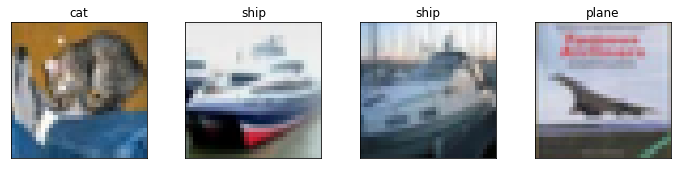

In [62]:
dataiter = iter(testloader)
images, labels = dataiter.next()

fig, axes = plt.subplots(1, len(images), figsize=(12,2.5))
for idx, image in enumerate(images):
    axes[idx].imshow(convert_to_imshow_format(image))
    axes[idx].set_title(classes[labels[idx]])
    axes[idx].set_xticks([])
    axes[idx].set_yticks([])

In [65]:
# Takes about 2 minutes

ouputs = net(images)
sm = nn.Softmax(dim=1)
sm_outputs = sm(outputs)

probs, index = torch.max(sm_outputs, dim=1)

for p, i in zip(probs, index):
    print('{0} - {1:.4f}'.format(classes[i], p))
    
total_correct = 0
total_images = 0
confusion_matrix = np.zeros([10,10], int)
with torch.no_grad():
    count = 0
    for data in testloader:
        print(f"Progress:{count/25}%")
        count += 1
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total_images += labels.size(0)
        total_correct += (predicted == labels).sum().item()
        for i, l in enumerate(labels):
            confusion_matrix[l.item(), predicted[i].item()] += 1 

model_accuracy = total_correct / total_images * 100
print('Model accuracy on {0} test images: {1:.2f}%'.format(total_images, model_accuracy))

car - 0.5980
truck - 0.5581
plane - 0.4285
ship - 0.5706
Progress:0.0%
Progress:0.04%
Progress:0.08%
Progress:0.12%
Progress:0.16%
Progress:0.2%
Progress:0.24%
Progress:0.28%
Progress:0.32%
Progress:0.36%
Progress:0.4%
Progress:0.44%
Progress:0.48%
Progress:0.52%
Progress:0.56%
Progress:0.6%
Progress:0.64%
Progress:0.68%
Progress:0.72%
Progress:0.76%
Progress:0.8%
Progress:0.84%
Progress:0.88%
Progress:0.92%
Progress:0.96%
Progress:1.0%
Progress:1.04%
Progress:1.08%
Progress:1.12%
Progress:1.16%
Progress:1.2%
Progress:1.24%
Progress:1.28%
Progress:1.32%
Progress:1.36%
Progress:1.4%
Progress:1.44%
Progress:1.48%
Progress:1.52%
Progress:1.56%
Progress:1.6%
Progress:1.64%
Progress:1.68%
Progress:1.72%
Progress:1.76%
Progress:1.8%
Progress:1.84%
Progress:1.88%
Progress:1.92%
Progress:1.96%
Progress:2.0%
Progress:2.04%
Progress:2.08%
Progress:2.12%
Progress:2.16%
Progress:2.2%
Progress:2.24%
Progress:2.28%
Progress:2.32%
Progress:2.36%
Progress:2.4%
Progress:2.44%
Progress:2.48%
Progress:2.

Progress:21.2%
Progress:21.24%
Progress:21.28%
Progress:21.32%
Progress:21.36%
Progress:21.4%
Progress:21.44%
Progress:21.48%
Progress:21.52%
Progress:21.56%
Progress:21.6%
Progress:21.64%
Progress:21.68%
Progress:21.72%
Progress:21.76%
Progress:21.8%
Progress:21.84%
Progress:21.88%
Progress:21.92%
Progress:21.96%
Progress:22.0%
Progress:22.04%
Progress:22.08%
Progress:22.12%
Progress:22.16%
Progress:22.2%
Progress:22.24%
Progress:22.28%
Progress:22.32%
Progress:22.36%
Progress:22.4%
Progress:22.44%
Progress:22.48%
Progress:22.52%
Progress:22.56%
Progress:22.6%
Progress:22.64%
Progress:22.68%
Progress:22.72%
Progress:22.76%
Progress:22.8%
Progress:22.84%
Progress:22.88%
Progress:22.92%
Progress:22.96%
Progress:23.0%
Progress:23.04%
Progress:23.08%
Progress:23.12%
Progress:23.16%
Progress:23.2%
Progress:23.24%
Progress:23.28%
Progress:23.32%
Progress:23.36%
Progress:23.4%
Progress:23.44%
Progress:23.48%
Progress:23.52%
Progress:23.56%
Progress:23.6%
Progress:23.64%
Progress:23.68%
Progr

Progress:41.92%
Progress:41.96%
Progress:42.0%
Progress:42.04%
Progress:42.08%
Progress:42.12%
Progress:42.16%
Progress:42.2%
Progress:42.24%
Progress:42.28%
Progress:42.32%
Progress:42.36%
Progress:42.4%
Progress:42.44%
Progress:42.48%
Progress:42.52%
Progress:42.56%
Progress:42.6%
Progress:42.64%
Progress:42.68%
Progress:42.72%
Progress:42.76%
Progress:42.8%
Progress:42.84%
Progress:42.88%
Progress:42.92%
Progress:42.96%
Progress:43.0%
Progress:43.04%
Progress:43.08%
Progress:43.12%
Progress:43.16%
Progress:43.2%
Progress:43.24%
Progress:43.28%
Progress:43.32%
Progress:43.36%
Progress:43.4%
Progress:43.44%
Progress:43.48%
Progress:43.52%
Progress:43.56%
Progress:43.6%
Progress:43.64%
Progress:43.68%
Progress:43.72%
Progress:43.76%
Progress:43.8%
Progress:43.84%
Progress:43.88%
Progress:43.92%
Progress:43.96%
Progress:44.0%
Progress:44.04%
Progress:44.08%
Progress:44.12%
Progress:44.16%
Progress:44.2%
Progress:44.24%
Progress:44.28%
Progress:44.32%
Progress:44.36%
Progress:44.4%
Progr

Progress:62.64%
Progress:62.68%
Progress:62.72%
Progress:62.76%
Progress:62.8%
Progress:62.84%
Progress:62.88%
Progress:62.92%
Progress:62.96%
Progress:63.0%
Progress:63.04%
Progress:63.08%
Progress:63.12%
Progress:63.16%
Progress:63.2%
Progress:63.24%
Progress:63.28%
Progress:63.32%
Progress:63.36%
Progress:63.4%
Progress:63.44%
Progress:63.48%
Progress:63.52%
Progress:63.56%
Progress:63.6%
Progress:63.64%
Progress:63.68%
Progress:63.72%
Progress:63.76%
Progress:63.8%
Progress:63.84%
Progress:63.88%
Progress:63.92%
Progress:63.96%
Progress:64.0%
Progress:64.04%
Progress:64.08%
Progress:64.12%
Progress:64.16%
Progress:64.2%
Progress:64.24%
Progress:64.28%
Progress:64.32%
Progress:64.36%
Progress:64.4%
Progress:64.44%
Progress:64.48%
Progress:64.52%
Progress:64.56%
Progress:64.6%
Progress:64.64%
Progress:64.68%
Progress:64.72%
Progress:64.76%
Progress:64.8%
Progress:64.84%
Progress:64.88%
Progress:64.92%
Progress:64.96%
Progress:65.0%
Progress:65.04%
Progress:65.08%
Progress:65.12%
Prog

Progress:83.36%
Progress:83.4%
Progress:83.44%
Progress:83.48%
Progress:83.52%
Progress:83.56%
Progress:83.6%
Progress:83.64%
Progress:83.68%
Progress:83.72%
Progress:83.76%
Progress:83.8%
Progress:83.84%
Progress:83.88%
Progress:83.92%
Progress:83.96%
Progress:84.0%
Progress:84.04%
Progress:84.08%
Progress:84.12%
Progress:84.16%
Progress:84.2%
Progress:84.24%
Progress:84.28%
Progress:84.32%
Progress:84.36%
Progress:84.4%
Progress:84.44%
Progress:84.48%
Progress:84.52%
Progress:84.56%
Progress:84.6%
Progress:84.64%
Progress:84.68%
Progress:84.72%
Progress:84.76%
Progress:84.8%
Progress:84.84%
Progress:84.88%
Progress:84.92%
Progress:84.96%
Progress:85.0%
Progress:85.04%
Progress:85.08%
Progress:85.12%
Progress:85.16%
Progress:85.2%
Progress:85.24%
Progress:85.28%
Progress:85.32%
Progress:85.36%
Progress:85.4%
Progress:85.44%
Progress:85.48%
Progress:85.52%
Progress:85.56%
Progress:85.6%
Progress:85.64%
Progress:85.68%
Progress:85.72%
Progress:85.76%
Progress:85.8%
Progress:85.84%
Progr

In [66]:
print('{0:10s} - {1}'.format('Category','Accuracy'))
for i, r in enumerate(confusion_matrix):
    print('{0:10s} - {1:.1f}'.format(classes[i], r[i]/np.sum(r)*100))

Category   - Accuracy
plane      - 55.6
car        - 65.2
bird       - 10.9
cat        - 24.2
deer       - 8.6
dog        - 41.0
frog       - 66.0
horse      - 62.2
ship       - 49.8
truck      - 49.4


## 4. Using the first CNN you trained, build another binary classifer that classifies images as ’Plane’ or ’Not Plane’. Compute the AUC of this binary classifier. Retrain this classifier to improve the AUC for this binary classification task. Report how you did that and what is the best AUC you were able to obtain.

In [85]:
class BinaryNet(nn.Module):
    def __init__(self):
        super(BinaryNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 2)
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [86]:
net = BinaryNet()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [87]:
# Have to download again to make labels binary

trainset = torchvision.datasets.CIFAR10(root='/home/CIFAR-10 Classifier Using CNN in PyTorch2/data/',
                                       train=True,
                                       download=True,
                                       transform=transform)

Files already downloaded and verified


In [88]:
testset = torchvision.datasets.CIFAR10(root='/home/CIFAR-10 Classifier Using CNN in PyTorch2/data',
                                      train=False,
                                      download=True,
                                      transform=transform)

Files already downloaded and verified


In [89]:
for target in range(len(trainset.targets)):
    if trainset.targets[target] != 0:
        trainset.targets[target] = 1

for target in range(len(testset.targets)):
    if testset.targets[target] != 0:
        testset.targets[target] = 1

In [90]:
trainloader = torch.utils.data.DataLoader(trainset,
                                         shuffle=True)
testloader = torch.utils.data.DataLoader(testset,
                                        shuffle=False)

In [91]:
for epoch in range(2):
        
    running_loss = 0
    for i, data in enumerate(trainloader, 0):

        inputs, labels = data

        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i%2000 == 1999:
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

    print('Finished Training.')
    torch.save(net.state_dict(), model_path)
    print('Saved model parameters to disk.')
    print(f"{(time.time() - start_time)/60} minutes")

[1,  2000] loss: 0.306
[1,  4000] loss: 0.265
[1,  6000] loss: 0.284
[1,  8000] loss: 0.268
[1, 10000] loss: 0.279
[1, 12000] loss: 0.274
[1, 14000] loss: 0.242
[1, 16000] loss: 0.239
[1, 18000] loss: 0.250
[1, 20000] loss: 0.235
[1, 22000] loss: 0.237
[1, 24000] loss: 0.198
[1, 26000] loss: 0.244
[1, 28000] loss: 0.247
[1, 30000] loss: 0.251
[1, 32000] loss: 0.212
[1, 34000] loss: 0.240
[1, 36000] loss: 0.232
[1, 38000] loss: 0.209
[1, 40000] loss: 0.214
[1, 42000] loss: 0.224
[1, 44000] loss: 0.216
[1, 46000] loss: 0.246
[1, 48000] loss: 0.212
[1, 50000] loss: 0.233
Finished Training.
Saved model parameters to disk.
66.33321323394776 minutes
[2,  2000] loss: 0.205
[2,  4000] loss: 0.216
[2,  6000] loss: 0.175
[2,  8000] loss: 0.203
[2, 10000] loss: 0.206
[2, 12000] loss: 0.210
[2, 14000] loss: 0.201
[2, 16000] loss: 0.199
[2, 18000] loss: 0.191
[2, 20000] loss: 0.195
[2, 22000] loss: 0.223
[2, 24000] loss: 0.209
[2, 26000] loss: 0.222
[2, 28000] loss: 0.212
[2, 30000] loss: 0.197
[2,

In [92]:
ouputs = net(images)
sm = nn.Softmax(dim=1)
sm_outputs = sm(outputs)

probs, index = torch.max(sm_outputs, dim=1)

total_correct = 0
total_images = 0

predictions = []
correct_labels = []

with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        correct_labels.extend(labels.numpy().tolist())
        predictions.extend(predicted.numpy().tolist())
        total_images += labels.size(0)
        total_correct += (predicted == labels).sum().item()

print(f"AUC:{roc_auc_score(correct_labels, predictions)}")

AUC:0.7287222222222223
